# 다양한 OCR모델 비교하기

## Step1. 검증용 데이터셋 준비

unplash, pixabay에서 이미지들을 준비

In [40]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread

dir_path = os.getenv('HOME') + '/aiffel/ocr_python/images'
samples = glob.glob(dir_path+'/*jpg')

samples

['/aiffel/aiffel/ocr_python/images/sample7.jpg',
 '/aiffel/aiffel/ocr_python/images/sample4.jpg',
 '/aiffel/aiffel/ocr_python/images/sample6.jpg',
 '/aiffel/aiffel/ocr_python/images/sample3.jpg']

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 2-1 Google OCR API

In [41]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
   
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

-rw-r--r-- 1 root root 2336 Nov 25 02:35 /aiffel/aiffel/ocr_python/my_google_api_key.json


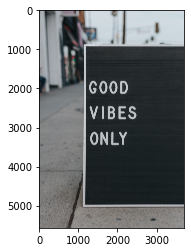

Texts:

"SWINGFRAME
GOOD
VIBES
ONLY
"

"SWINGFRAME"

"GOOD"

"VIBES"

"ONLY"
bounds: (1312,3112),(2255,3112),(2255,3447),(1312,3447)


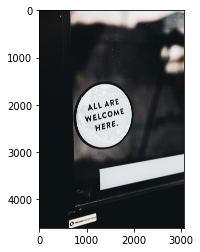

Texts:

"ALL ARE
WELCOME
HERE.
Oldeastle BuildingEnvelope"
"

"ALL"

"ARE"

"WELCOME"

"HERE."

"Oldeastle"

"BuildingEnvelope""
bounds: (930,4434),(1204,4360),(1215,4401),(941,4476)


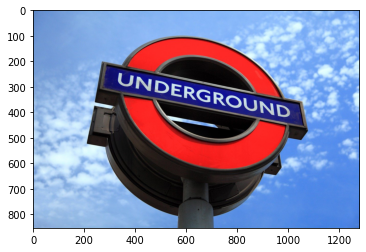

Texts:

"UNDERGROUND
"

"UNDERGROUND"
bounds: (336,244),(1010,377),(1001,424),(327,291)


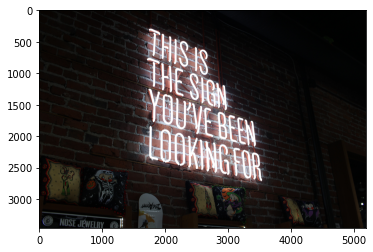

Texts:

"THIS IS
THE SIGN
YOU'VE BEEN
LOOKING FOR
NOSE JEWELRY
"

"THIS"

"IS"

"THE"

"SIGN"

"YOU'VE"

"BEEN"

"LOOKING"

"FOR"

"NOSE"

"JEWELRY"
bounds: (619,3311),(1029,3339),(1020,3471),(610,3443)


In [42]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'
   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for sample in samples:
    img = imread(sample)
    plt.imshow(img)
    plt.show()
    detect_text(sample)

### 2-2 keras-ocr

In [43]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [44]:
images = [keras_ocr.tools.read(sample) for sample in samples]
prediction_groups = [pipeline.recognize([sample]) for sample in samples]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


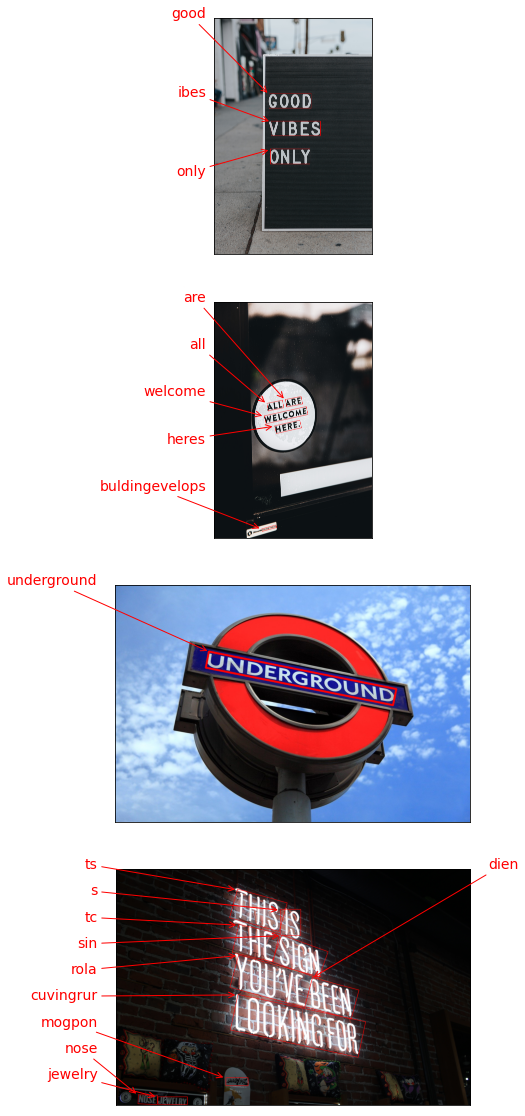

In [45]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2-3 Tesseract

In [56]:
dir_path = os.getenv('HOME') + '/aiffel/ocr_python/images'
samples = glob.glob(dir_path+'/*jpg')

samples

['/aiffel/aiffel/ocr_python/images/sample7.jpg',
 '/aiffel/aiffel/ocr_python/images/sample0.jpg',
 '/aiffel/aiffel/ocr_python/images/sample4.jpg',
 '/aiffel/aiffel/ocr_python/images/sample6.jpg',
 '/aiffel/aiffel/ocr_python/images/sample3.jpg']

In [57]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
            
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")
    


# work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
# img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

# cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

In [58]:
image_name=[]

for sample in samples:
    image_name.append(sample[-11:])
    
print(image_name)

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'


['sample7.jpg', 'sample0.jpg', 'sample4.jpg', 'sample6.jpg', 'sample3.jpg']


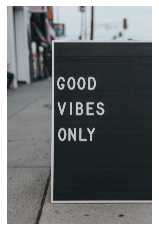

/aiffel/aiffel/ocr_python/images/0000.png

Done


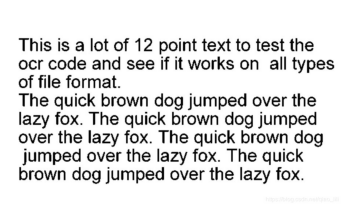

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png
/aiffel/aiffel/ocr_python/images/0009.png
/aiffel/aiffel/ocr_python/images/0010.png
/aiffel/aiffel/ocr_python/images/0011.png
/aiffel/aiffel/ocr_python/images/0012.png
/aiffel/aiffel/ocr_python/images/0013.png
/aiffel/aiffel/ocr_python/images/0014.png
/aiffel/aiffel/ocr_python/images/0015.png
/aiffel/aiffel/ocr_python/images/0016.png
/aiffel/aiffel/ocr_python/images/0017.png
/aiffel/aiffel/ocr_python/images/0018.png
/aiffel/aiffel/ocr_python/images/0019.png
/aiffel/aiffel/ocr_python/images/0020.png
/aiffel/aiffel/ocr_python/images/0021.png
/aiffel/aiffel/ocr_python/images/0022.png
/aiffel/aiffel/ocr_python/images/0

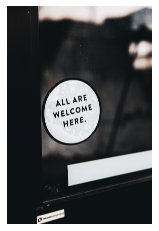

/aiffel/aiffel/ocr_python/images/0000.png

Done


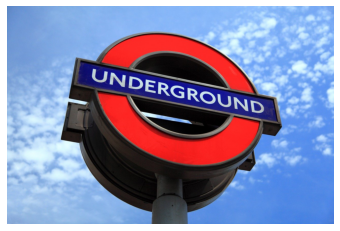

/aiffel/aiffel/ocr_python/images/0000.png

Done


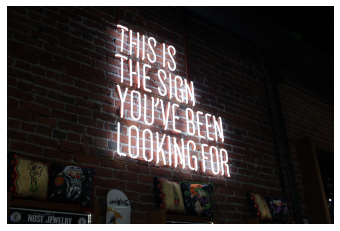

/aiffel/aiffel/ocr_python/images/0000.png
|

Done


In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as img

save_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'

for name in image_name:
    
    try:
        jpg = img.imread(os.path.join(work_dir, name))
        plt.imshow(jpg)       
        plt.axis("off")
        plt.show()
        crop_word_regions(os.path.join(work_dir, name), save_dir)
    except:
        print(f'Cannot recognize characters from {names}')

## Step3. 테스트 결과 정리
- 네온사인 이미지 테스트 결과를 비교해보겠다.
### 1. Google OCR API 
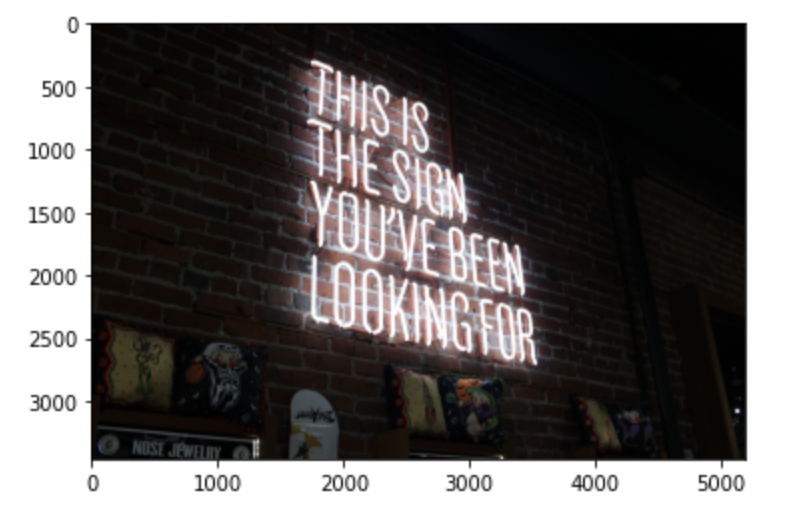
Texts:

"THIS IS
THE SIGN
YOU'VE BEEN
LOOKING FOR
NOSE JEWELRY
"

"THIS"

"IS"

"THE"

"SIGN"

"YOU'VE"

"BEEN"

"LOOKING"

"FOR"

"NOSE"

"JEWELRY"
bounds: (619,3311),(1029,3339),(1020,3471),(610,3443)

### 2. keras-ocr
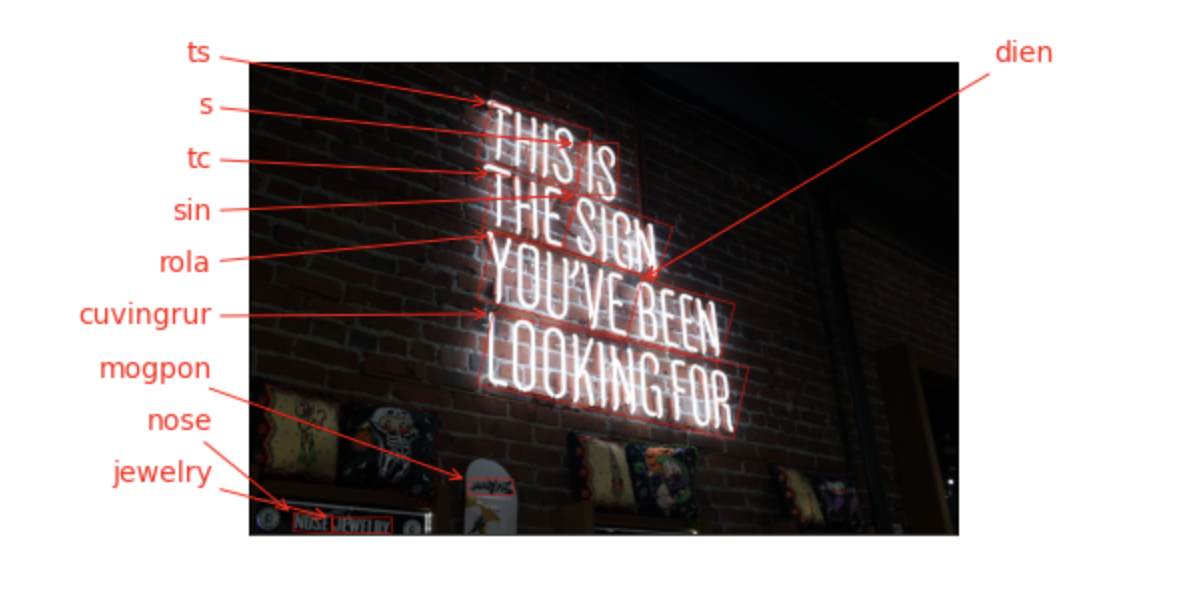

### 3. tesseract
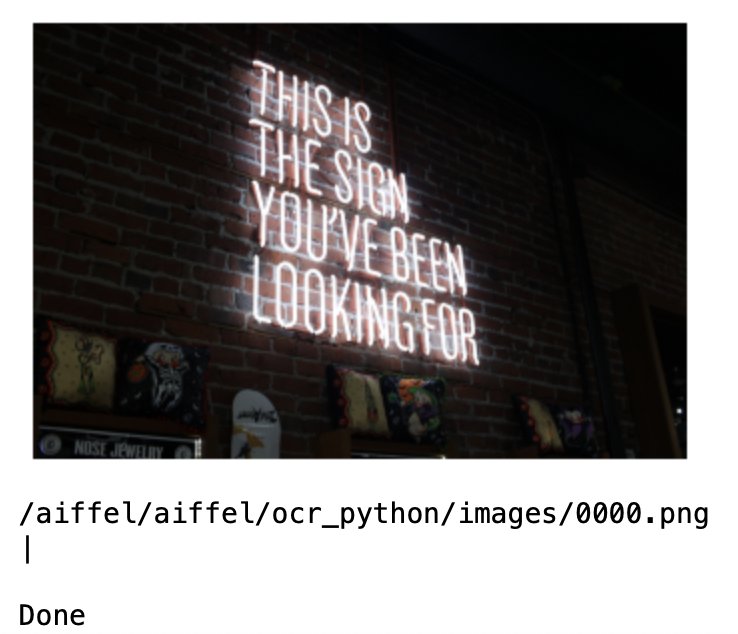

## Step4. 결과 분석과 결론 제시
1. 길거리에서 쉽게 볼 수 있는 표지판, 간판들을 읽어내는 ocr 모델을 만들고자 했다.
2. 평가 기준 : 작은 글씨, 큰 글씨, 네온 사인 등 다양한 크기와 모양의 글씨를 읽어 낼 수 있는가.  
2-1. Google OCR API : 내가 준비한 이미지들의 텍스트들을 거의 정확하게 출력했다. 문장 단위로도, 단어 단위로도 출력했다.  
2-2. keras-ocr : 네온사인 간판을 제외하고는 거의 정확하게 출력했다.   
2-3. Tesseract : 준비한 이미지들에서 텍스트들을 출력하지 못했다.  

3. 평가 기준을 봤을 때 Google OCR API가 가장 훌륭했다.

## 회고
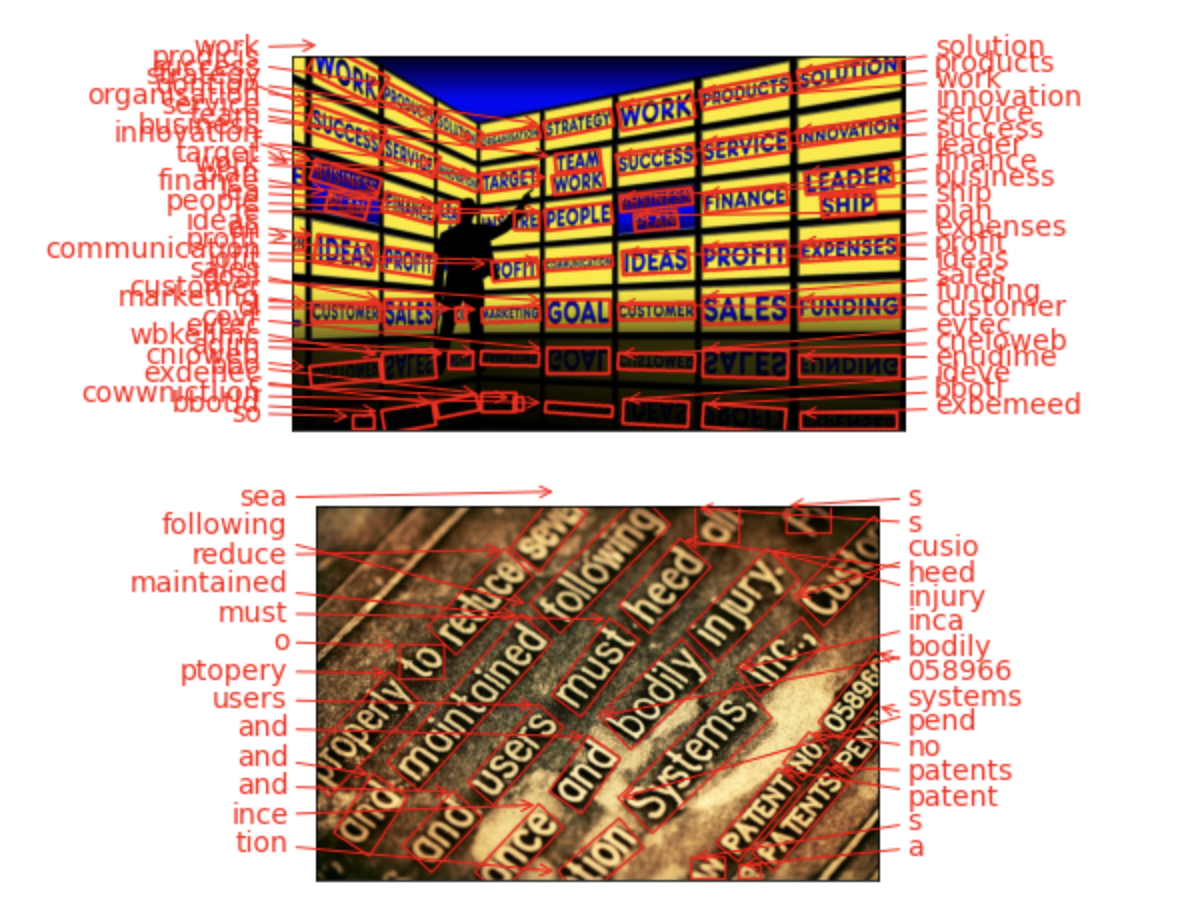
- 글자가 너무 많은 건 keras ocr로 알아보기 힘들어서 샘플 이미지에서 제외 했다.
- 'NoneType' object is not iterable 오류가 자꾸 떠서 recognize_images 함수를 crop_word_regions와 합쳤다.
- 원래 사용한 샘플 이미지들로 tesseract로 ocr을 수행하니깐 텍스트를 못 읽어내길래 하얀배경에 정직하게 쓰인 텍스트 사진을 테스트로 해보니깐 잘 읽었다. 하지만 예상한 텍스트가 아닌 엉뚱한 텍스트들을 출력했다.